In [1]:
""" 
- Project: Bigdata
- Editor: Jo woosueng
- Recent Edit data: 221110
"""
## Module
import numpy as np
import pandas as pd
import torch
import os
import importlib
from scipy import io
from datetime import datetime
import matplotlib.pyplot as plt
import PreProcess
importlib.reload(PreProcess)

ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
current_path = os.getcwd()
use_datetime = 'BaseCase'
Today = datetime.today().strftime("%y%m%d")
print("Today: ", Today,  "\nCurrent path: ", current_path)

Today:  221110 
Current path:  c:\Lab\Project\Bigdata_BaseCase


In [2]:
"""
기초 데이터 생성
"""
import PreProcess
importlib.reload(PreProcess)

PreProcess.MakeFolder(current_path, use_datetime)
PreProcess.DivideSource(current_path)
PreProcess.ClassifyByReportedType(current_path, use_datetime)

In [3]:
importlib.reload(PreProcess)
"""
Oil/Gas에 따른 Shut-in 전처리 및 데이터 생성(Max Production 이후 자르는 전처리도 가능)
"""
######################## Control Pannel ########################
use_datetime = 'BaseCase'
criteria_for_preprocess = 'GasProd_MCF' # 'LiquidsProd_BBL' / 'GasProd_MCF' / 'Prod_BOE'
Use_or_not_maxidx_preprocess = 0 # Turn on = 1 or not 0
minval_for_maxidx = 6
Use_or_not_shutin_preprocess = 1 # Turn on = 1 or not 0
minval_for_shutin = 0 # Shut-in crteria for amount
minDataNum = 0 # 뽑을 최소 길이, 이는 전처리 후 길이를 의미함
######################## Control Pannel ########################
PreProcess.Generate_SI(current_path, use_datetime, criteria_for_preprocess, Use_or_not_maxidx_preprocess, minval_for_maxidx, Use_or_not_shutin_preprocess, minval_for_shutin, minDataNum)

In [10]:
"""
!!!!!!!!!!!!!!!!!중요!!!!!!!!!!!!!!!!!!!!!! 여기서 히스토그램 그려본다음 유정 생산량이 너무 작은 애들은 애초에 Refrac 생성할 때 제한조건 걸어서 빼버리고자함, 기준은 최대생산량을 도시한 뒤, 최대 생산량이 분포와 떨어져 있는 부분을 자를 거임.

데이터 분석을 위한 Histogram 그리기
Oil로 분류된 유정의 Oil & Gas
Gas로 분류된 유정의 Oil & Gas
1) 총 생산량 Histogram --> Cum 참조
2) 총 생산일수 Histogram (총 생산일 수임) --> CumDay 참조

--- 한 번씩 다 읽어야 알 수있는 구조 ---
3) Max Idx 위치 Histogram --> Prod Rate를 기준 
4) 모든 생산 시점의 생산량이 x 이하인 유정 (이 기준은 일단 총생산량 Hist를 그려보고 결정해야하겠네. 초기값으로 Liq는 10, Gas는 10,000) True or False / 'MinProd'라 명명
--> 즉 최대 생산량이 기준 생산량보다 작은 유정에 1을 할당 --> 1인 애들 다 지우려고
"""
## Oil 먼저 --> 위에서 Oil을 기준으로 전처리하면, Oil로 분류된 유정만 가져오기 때문에 Oil & Gas를 구분해서 분석하는 것임
input_path = current_path + '/Data/Before_Refrac/' + use_datetime + '/'
input_filelst = os.listdir(input_path)
criteria_oil = 10
criteria_gas = 10000
CumProd_Oil_lst = []
CumProd_Gas_lst = []
CumDay_lst = []
MaxIdx_Oil_lst = []
MaxIdx_Gas_lst = []
MaxProd_Oil_lst = []
MaxProd_Gas_lst = []
AvgProd_Oil_lst = []
AvgProd_Gas_lst = []

for file in input_filelst:
    df_tmp = pd.read_csv(input_path + file)
    CumProd_Oil_lst = np.append(CumProd_Oil_lst, df_tmp['CumLiquids_BBL'][-1:].values.astype(float))
    CumProd_Gas_lst = np.append(CumProd_Gas_lst, df_tmp['CumGas_MCF'][-1:].values.astype(float))
    CumDay_lst = np.append(CumDay_lst, df_tmp['CumProdDay'][-1:].values.astype(int))
    try: MaxIdx_Oil_lst = np.append(MaxIdx_Oil_lst, df_tmp['TotalProdMonths'][df_tmp['LiquidsProd_BBL'].idxmax(skipna=True)]) # 파이썬 인덱스가 아닌 생산 월수를 기준으로하였음
    except: MaxIdx_Oil_lst = np.append(MaxIdx_Oil_lst, 0)
    try : MaxIdx_Gas_lst = np.append(MaxIdx_Gas_lst, df_tmp['TotalProdMonths'][df_tmp['GasProd_MCF'].idxmax(skipna=True)])
    except:MaxIdx_Gas_lst = np.append(MaxIdx_Gas_lst, 0)

    try: MaxProd_Oil_lst = np.append(MaxProd_Oil_lst, df_tmp['LiquidsProd_BBL'][df_tmp['LiquidsProd_BBL'].idxmax(skipna=True)]) # 파이썬 인덱스가 아닌 생산 월수를 기준으로하였음
    except: MaxProd_Oil_lst = np.append(MaxProd_Oil_lst, 0)
    try : MaxProd_Gas_lst = np.append(MaxProd_Gas_lst, df_tmp['GasProd_MCF'][df_tmp['GasProd_MCF'].idxmax(skipna=True)])
    except:MaxProd_Gas_lst = np.append(MaxProd_Gas_lst, 0)

    try: AvgProd_Oil_lst = np.append(AvgProd_Oil_lst, df_tmp['LiquidsProd_BBL'].mean()) # 파이썬 인덱스가 아닌 생산 월수를 기준으로하였음
    except: AvgProd_Oil_lst = np.append(AvgProd_Oil_lst, 0)
    try : AvgProd_Gas_lst = np.append(AvgProd_Gas_lst, df_tmp['GasProd_MCF'].mean())
    except:AvgProd_Gas_lst = np.append(AvgProd_Gas_lst, 0)

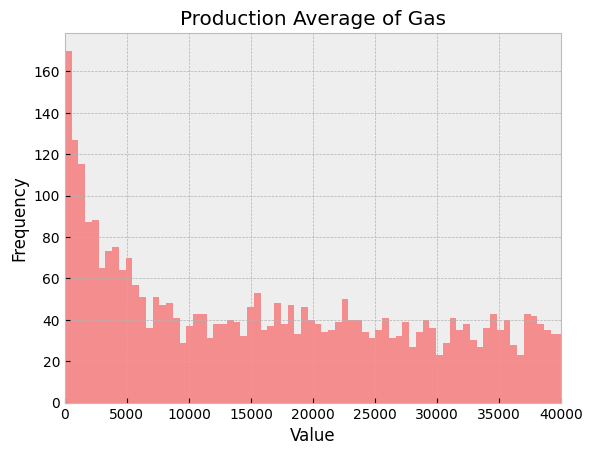

In [29]:
# CumProd_Oil_lst = []
# CumProd_Gas_lst = []
# CumDay_lst = []
# MaxIdx_Oil_lst = []
# MaxIdx_Gas_lst = []
n, bins, patches = plt.hist(AvgProd_Gas_lst, 1000, density=False, facecolor='r', alpha=0.4)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Production Average of Gas')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(0, 40000)
# plt.ylim(0, 0.03)
plt.grid(True)
plt.savefig(current_path + '/Figs/Histogram/AvgProd_Gas_lst.png', dpi=300)
plt.show()


In [40]:
importlib.reload(PreProcess)
"""
Oil/Gas에 따른 Refrac 탐색 및 데이터 생성
"""
######################## Control Pannel ########################
use_datetime = 'BaseCase'
criteria_for_Refrac = "GasProd_MCF" # 'LiquidsProd_BBL' / 'GasProd_MCF' / 'Prod_BOE'
rambda_gas = 1.5 # 최적화를 통해 얻어진 값
rambda_water = 1.5 # 최적화를 통해 얻어진 값
min_criteria = 3 # 최적화를 통해 얻어진 값, 스케일링된 최소값을 의미하며 너무 작은 진동에 움직이지 않도록 설정
min_month = 12 # LSTM 추가 데이터 확보를 위한 기준
EUR_criteria = 60 # 우선 Refrac 과정에서는 EUR_criteria를 기준으로 이것보다 작으면 Train, 이것보다 크면 Test로 분류
criteria_of_avg = 5000
criteria_max_idx = 6 # 6개월 이하에서는 Refrac이 안잡히도록 설정
######################## Control Pannel ########################

PreProcess.Generate_Refrac(current_path, use_datetime, criteria_for_Refrac, criteria_of_avg, criteria_max_idx, rambda_gas, rambda_water, min_criteria, min_month, EUR_criteria)

Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.
Error become Found array with 0 sampl

In [32]:
import Graph
# For Delawar Gas
Last_Refrac_lst_train, Last_Refrac_lst_test, Last_Months_lst = Graph.Histogram_Tot_and_LastRefrac(current_path, use_datetime)
fig, ax = plt.subplots()

ax.hist(Last_Refrac_lst_test, color='Red', alpha=0.2, bins=np.linspace(20, 220, 11, dtype=int), edgecolor='black', label='Refrac', density=False)
ax.set(xlim=(0, 260), xticks=np.linspace(0, 220, 12, dtype=int), xlabel='Last Refrac Months', ylabel='# of Well')
plt.legend()
plt.savefig(current_path + '/Figs/Histogram/LastRefracMonth.png', dpi=300)
plt.show()

fig, ax = plt.subplots()
ax.hist(Last_Months_lst, color='green', alpha=0.4, bins=np.linspace(60, 260, 11, dtype=int), edgecolor='black', label='TotalProdMonths', density=False)
ax.set(xlim=(40, 280), xticks=np.linspace(60, 260, 11, dtype=int), xlabel='Last Months', ylabel='# of Well')
plt.legend()
plt.savefig(current_path + '/Figs/Histogram/TotalProdMonth.png', dpi=300)
plt.show()

ModuleNotFoundError: No module named 'Graph'

In [41]:
importlib.reload(PreProcess)
"""
Refrac 데이터 8.5:1.5 으로 나눈 뒤 
Refrac 없는 데이터만 가지고 Train:Test 데이터를 나눔 8.5:1.5
해당 엑셀파일을 뽑아줌 (RF랑 비교용)
"""
seed = 1
use_datetime = 'BaseCase'
PreProcess.FileListExtract(current_path, use_datetime, seed)

In [61]:
########################### Start of Control Pannel ###########################
"""
    - It should be same with the number of num_features and sum of use_or_not_features.
    - Ex. use_or_not_CumMonth = 1 means you will use that parameter.
"""
importlib.reload(PreProcess)

use_or_not_ProdBOE    = 0    # Ex. 3000, 1000, 500, ...
use_or_not_DailyRate  = 0    # Ex. 100, 90, 40, ...  = ProdBOE/ProdDays
use_or_not_CumProdBOE = 0    # Ex. 3000, 4000, 4500, ...
use_or_not_OilProd    = 0
use_or_not_OilRate    = 0
use_or_not_CumOil     = 0
use_or_not_GasProd    = 1
use_or_not_GasRate    = 0
use_or_not_CumGas     = 1
use_or_not_WaterProd  = 0 

use_or_not_CumMonth   = 0    # Ex. 1, 2, 3, 4, ...
use_or_not_ProdDays   = 1    # Ex. 30, 31, 29, 5, ...
use_or_not_CumProdDay = 1      
use_or_not_Shutin     = 1    # Ex. 0, 1, 0, 0, 2, 0, ...
use_or_not_Refrac     = 1

Choose_num_of_output_parameter = 2
Choose_num_of_first_output_parameter = 7
Choose_num_of_second_output_parameter = 9

########################### End of Control Pannel ###########################

used_features, name_of_used_features, num_of_features = PreProcess.Set_Var(Choose_num_of_first_output_parameter, Choose_num_of_second_output_parameter, use_or_not_ProdBOE, use_or_not_DailyRate, use_or_not_CumProdBOE, 
                                                                            use_or_not_OilProd, use_or_not_OilRate, use_or_not_CumOil, use_or_not_GasProd, use_or_not_GasRate, use_or_not_CumGas, 
                                                                            use_or_not_WaterProd, use_or_not_CumMonth, use_or_not_ProdDays, use_or_not_CumProdDay, use_or_not_Shutin, use_or_not_Refrac)

Input features = ['GasProd_MCF' 'CumGas_MCF' 'ProducingDays' 'CumProdDay' 'ShutinMonths'
 'Refrac']
Onput features = GasProd_MCF CumGas_MCF


In [62]:
num_of_features

6

In [74]:
"""
Train Model, 모델은 Model 폴더에 사용된 변수와 해당 날짜로 저장됨.
"""
import Train
importlib.reload(Train)
########################### Start of Control Pannel #########################
use_datetime = 'BaseCase' # Check the data in the Data dictionary.
seq_length = 3
lamda = 0 ### 생산량과 누적생산량 맞추기 비율, 앞에 lamda 붙어있음 (확인 다시 필요)
choose_scaler = 1 # 1=standard, 2=minmax, 3=Robust, 4=QuantileTransformer, 5=PowerTransformer
num_of_out_features = 2
seed = 1
############################## Hyperparameters ##############################
batch_size = 128 # 128
num_epochs = 100
learning_rate = 1e-2 # 1e-3
hidden_size = 128
num_layers = 3
num_classes = 1
best_val_loss = 1
########################### End of Control Pannel ###########################
Train.TrainModel(current_path, use_datetime, lamda, choose_scaler, used_features, name_of_used_features, num_of_features, seed,
num_of_out_features, seq_length, batch_size=128, num_epochs=300, learning_rate=1e-2, hidden_size=128, num_layers=3, num_classes=1, best_val_loss=0.1)

(101511, 3, 6)
(22284, 3, 6)


Saved best model epoch: 0 val loss is: 0.06463378667831421 train loss is 0.08370202779769897
Epoch: 0, loss: 0.08370 valid loss:  0.06463 
Saved best model epoch: 1 val loss is: 0.045577272772789 train loss is 0.003668048419058323
Saved best model epoch: 10 val loss is: 0.001888582482933998 train loss is 0.0588773749768734
Epoch: 10, loss: 0.05888 valid loss:  0.00189 
Epoch: 20, loss: 0.20188 valid loss:  0.23363 
Epoch: 30, loss: 0.22249 valid loss:  0.27549 
Epoch: 40, loss: 0.05828 valid loss:  0.05873 
Epoch: 50, loss: 0.13890 valid loss:  0.19693 
Epoch: 60, loss: 0.07111 valid loss:  0.01528 
Epoch: 70, loss: 0.08026 valid loss:  0.07646 
Epoch: 80, loss: 0.04280 valid loss:  0.07074 
Epoch: 90, loss: 0.12474 valid loss:  0.01221 
Saved best model epoch: 95 val loss is: 0.0018817938398569822 train loss is 0.13594889640808105
Saved best model epoch: 96 val loss is: 0.0005351539584808052 train loss is 0.2242198884487152
Epoch: 100, loss: 1.99981 valid loss:  0.06592 
Epoch: 110, l

In [76]:
"""
Prediction, EUR을 구하여 R2를 구함 
"""
import Pred
importlib.reload(Pred)
########################### Start of Control Pannel #########################
test_input_path = current_path + '\\Data\\After_Preprocess\\' + use_datetime + '\\Test\\' ## Refrac만 Testdataset으로 할 때 해당 경로를 바꿔주면 됨
use_datetime = 'BaseCase' # Check the data in the Data dictionary.
seq_length = 3
seq_length_string = '3'
use_or_not_EUR_until_Last_months = 1 ## if 1 --> EUR_standard set by last months automatically. and then, below value(EUR standard) is no used.
used_period_lst = [3, 6, 9, 12] # used_period는 seq_length보다 짧아선 안됨. min of used_period = seq_length
used_period = used_period_lst[0] # Best, Worst Case 그릴때 얼마까지 사용해서 그릴것인지 결정
EUR_standard = 60
choose_scaler = 1  # 1=standard, 2=minmax, 3=Robust, 4=QuantileTransformer, 5=PowerTransformer
lamda = 0.5 # 여기서는 prediction 할 때 EUR을 계산하는 비율을 결정하는걸로, 학습시켰을 때 비랑 일정하게 하려고 함.
############################## Hyperparameters ##############################
learning_rate = 1e-3
hidden_size = 128
num_layers = 3
num_classes = 1
########################### End of Control Pannel ###########################
Pred.Prediction(current_path, test_input_path, use_datetime, lamda, choose_scaler, used_features, name_of_used_features, num_of_features, seq_length, use_or_not_EUR_until_Last_months, used_period_lst, EUR_standard, used_period, learning_rate, hidden_size, num_layers, num_classes)